In [1]:
# Importing libraries

import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [3]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,712,726,736,750,766,773,782,789,795,803
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,738,738,743,743,743,745,745,747,748,750
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,26,27,27,27,27,30,35,35,35


In [4]:
# Data Cleaning

df_US = df.loc[df['Country/Region'] == 'US']
ds_US = list(df_US.columns[4:].values)
ds_US = pd.to_datetime(ds_US)
days = (ds_US - datetime.strptime("2020-01-01", '%Y-%m-%d')).days.values
y_US = np.transpose(df_US[df_US.columns[4:]].values)

#### We will be checking from January 1, 2020, so map the df accordingly.

In [5]:
# Building dataframe

df_US = pd.DataFrame({'days': days, 'confirmedCases': y_US.ravel()})

In [6]:
df_US.tail()

,days,confirmedCases
99,120,1069424
100,121,1103461
101,122,1132539
102,123,1158040
103,124,1180375


### Logistic Model

In [7]:
# Define logistic function

def log_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [8]:
# Curve fitting

x = list(df_US.iloc[:,0])
y = list(df_US.iloc[:,1])
fit = curve_fit(log_model,x,y,p0=[4,100,1000000])

In [9]:
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
print('Rate of spread: ', a)
print('Date of max confirmed cases: ', (datetime.strptime("2020-01-01", '%Y-%m-%d')+ timedelta(days=b)).strftime('%B-%d-%Y'))
print('Total confirmed cases at the pandemic end date: ', c)

Rate of spread:  8.408277859494197
Date of max confirmed cases:  April-14-2020
Total confirmed cases at the pandemic end date:  1234050.7511355255


In [10]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [11]:
print(f'The expected number of confirmed cases at the end date is {round(c)} ± {round(errors[2])}.')

The expected number of confirmed cases at the end date is 1234051.0 ± 18822.0.


In [12]:
sol = int(fsolve(lambda x : log_model(x,a,b,c) - int(c),b))

In [13]:
predictedDate = (datetime.strptime("2020-01-01", '%Y-%m-%d')+ timedelta(days=sol)).strftime('%B-%d-%Y')
print("Covid pandemic end date: ", predictedDate)

Covid pandemic end date:  August-12-2020


### Exponential Model

In [14]:
# Define exponential function

def exp_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [15]:
# Curve fitting

exp_fit = curve_fit(exp_model,x,y, maxfev=5000)

In [16]:
ae = exp_fit[0][0]
be = exp_fit[0][1]
ce = exp_fit[0][2]
print('a: ', ae)
print('b: ', be)
print('c: ', ce)

a:  92.41980198103283
b:  0.05134707053967924
c:  -63.15310851005487


In [41]:
# Days to date custom function

def myDayToDT(x):
    d_list = []
    for i in x:
        myDt = (datetime.strptime("2020-01-01", '%Y-%m-%d')+ timedelta(days=i))
        d_list.append(myDt)
    return d_list

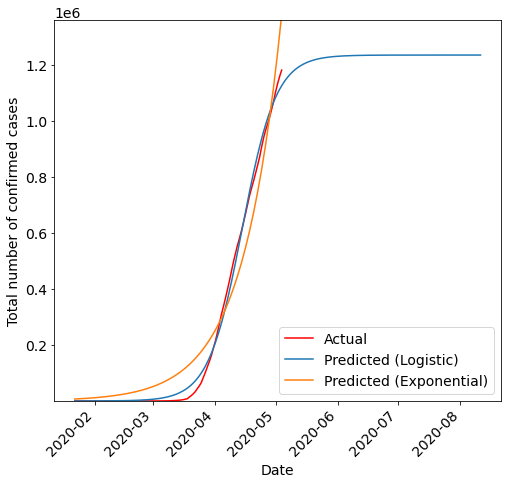

In [40]:
# Plotting both the curves along with actual data

ds_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [8, 7]
plt.rc('font', size=14)
plt.plot(myDayToDT(x),y,label="Actual",color="red")
plt.plot(myDayToDT(x+ds_x), [log_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+ds_x], label="Predicted (Logistic)" )
plt.plot(myDayToDT(x+ds_x), [exp_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+ds_x], label="Predicted (Exponential)" )
plt.legend()
plt.xlabel("Date")
plt.ylabel("Total number of confirmed cases")
plt.ylim((min(y)*0.9,c*1.1))
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
plt.yticks(fontweight='light')
plt.savefig('regression_future.png')
plt.show()